In [1]:
job_name_map = {
    "scrap_measurement_overhead": 694,
    "test": 696
}

In [2]:
import os
from pathlib import Path
import subprocess
from subprocess import CompletedProcess
import seaborn as sns
import matplotlib
import pandas as pd
from pandas import DataFrame

matplotlib.pyplot.ion()
%config InlineBackend.figure_formats = ['svg']
# sns.set_theme(style="whitegrid")
sns.set_theme(style="white")
sns.set_palette("colorblind")

def collect_job_metrics(exp_name, output_dir_name="metrics"):
    job_id = job_name_map[exp_name]
    command = ["colext_get_metrics", "-j", str(job_id)]
    output_dir = Path(f"metrics/{exp_name}")
    os.makedirs(output_dir, exist_ok=True)

    result: CompletedProcess = subprocess.run(command, capture_output=True, cwd=output_dir)
    if result.returncode != 0:
        print(f"ERROR: Could not collect job metrics for job_id = {job_id}")
        os.rmdir(output_dir)

    return output_dir

def reset_network_counts_to_min(group):
    min_index = group['time'].idxmin()

    min_n_bytes_sent = group.loc[min_index, 'n_bytes_sent']
    min_n_bytes_rcvd = group.loc[min_index, 'n_bytes_rcvd']

    group["n_bytes_sent"] -= min_n_bytes_sent
    group["n_bytes_rcvd"] -= min_n_bytes_rcvd
    return group

def read_job_metrics(exp_name, job_metric_dir):
    job_id = job_name_map[exp_name]
    path_prefix = f"{job_metric_dir}/colext_{job_id}"

    client_info: DataFrame = pd.read_csv(f"{path_prefix}_client_info.csv").set_index('client_id')
    round_timestamps: DataFrame = pd.read_csv(f"{path_prefix}_round_timestamps.csv", parse_dates=['start_time', 'end_time'])
    client_round_timings: DataFrame = pd.read_csv(f"{path_prefix}_client_round_timings.csv", parse_dates=['start_time', 'end_time'])
    hw_metrics: DataFrame = pd.read_csv(f"{path_prefix}_hw_metrics.csv", parse_dates=['time'])

    # Clip HW measurements to start at job start
    start_time = round_timestamps.query('round_number == 1 & stage == "FIT"')["start_time"][0]
    hw_metrics = hw_metrics[hw_metrics['time'] > start_time].copy()
    hw_metrics[:] = hw_metrics.groupby('client_id').apply(reset_network_counts_to_min)
    # Adjust units
    hw_metrics["mem_util"] = hw_metrics["mem_util"] / 1024 / 1024
    hw_metrics["power_consumption"] = hw_metrics["power_consumption"] / 1000
    # hw_metrics["n_bytes_sent"] = hw_metrics["n_bytes_sent"] / 1024 / 1024   # MiB
    # hw_metrics["n_bytes_rcvd"] = hw_metrics["n_bytes_rcvd"] / 1024 / 1024   # MiB
    hw_metrics["n_bytes_sent"] = hw_metrics["n_bytes_sent"] / 1024 # KiB
    hw_metrics["n_bytes_rcvd"] = hw_metrics["n_bytes_rcvd"] / 1024 # KiB
    hw_metrics["net_usage_out"] = hw_metrics["net_usage_out"] / 1024  # KiB/s
    hw_metrics["net_usage_in"] =  hw_metrics["net_usage_in"]  / 1024  # KiB/s

    # Rename columns
    client_round_timings.rename(columns={"client_number": "client_id"}, inplace=True)
    hw_metrics.rename(columns={"client_number": "client_id"}, inplace=True)
    hw_metrics.rename(columns={
        "cpu_util": "CPU Util (%)",
        "gpu_util": "GPU Util (%)",
        "mem_util": "Mem Util (MiB)",
        "power_consumption": "Power (W)",
        "n_bytes_sent": "Sent (KiB)",
        "n_bytes_rcvd": "Rcvd (KiB)",
        "net_usage_out": "Upload (KiB/s)",
        "net_usage_in":  "Download (KiB/s)",
        # "n_bytes_sent": "Sent (MiB)",
        # "n_bytes_rcvd": "Rcvd (MiB)",
        # "net_usage_out": "Upload (MiB/s)",
        # "net_usage_in":  "Download (MiB/s)",
        }, inplace=True)

    # Add client device name and type
    client_round_timings = client_round_timings.join(client_info, on="client_id")
    hw_metrics = hw_metrics.join(client_info, on="client_id")

    job_data = {}
    job_data["client_info"] = client_info
    job_data["client_round_timings"] = client_round_timings
    job_data["hw_metrics"] = hw_metrics
    job_data["round_timestamps"] = round_timestamps
    return job_data

def plot_hw_metrics(df, id_vars="device_type", save_name=None):
    """Convert to long format and print facetgrid with metrics"""
    # Convert to Long format
    df_long = pd.melt(df, id_vars=id_vars, var_name='metric')

    g = sns.FacetGrid(df_long, col="metric", hue="device_type", sharex=False, col_wrap=4)
    g.map(sns.barplot, "value", "device_type", orient="h", order=["JetsonAGXOrin", "JetsonOrinNano", "LattePandaDelta3", "OrangePi5B", "JetsonNano", "JetsonXavierNX"])
    g.set_axis_labels("", "")
    g.set_titles("{col_name}")
    if save_name:
        g.figure.savefig(f"plots/{save_name}")
    g.figure.show()


In [54]:
exp_name="scrap_measurement_overhead"
job_metric_dir = collect_job_metrics(exp_name)
job_data = read_job_metrics(exp_name, job_metric_dir)

In [55]:
job_data["hw_metrics"].groupby("device_name").mean(numeric_only=True)

,client_id,CPU Util (%),Mem Util (MiB),GPU Util (%),Power (W),Sent (KiB),Rcvd (KiB),Upload (KiB/s),Download (KiB/s)
device_name,,,,,,,,,
jao1,1.0,2.287870,47.024643,0.000000,7.183362,127.764551,25.662367,0.840462,0.193162
jao2,0.0,2.411133,46.937886,0.000000,6.834948,127.869956,28.841022,0.834838,0.216669
jn1,25.0,6.916158,46.824219,0.000000,1.976293,131.312092,34.312890,0.852145,0.244876
jn2,23.0,6.984653,48.398438,0.000000,1.913963,130.951889,33.350500,0.896377,0.246238
jn3,22.0,7.166796,46.393527,0.000000,1.891604,129.080645,33.294163,0.842736,0.237000
jn4,24.0,6.854835,48.152344,0.000000,1.927420,132.843395,34.969279,0.870995,0.233448
jn5,21.0,11.410895,49.253906,0.000000,2.032015,130.036395,33.519432,0.855230,0.243195
jn6,20.0,11.339279,49.000000,0.000000,1.869510,130.276482,33.673789,0.857664,0.245049
jon1,3.0,2.101097,46.726562,0.000000,4.959680,134.677835,27.900886,0.865069,0.188510


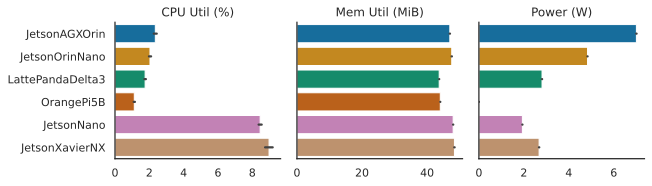

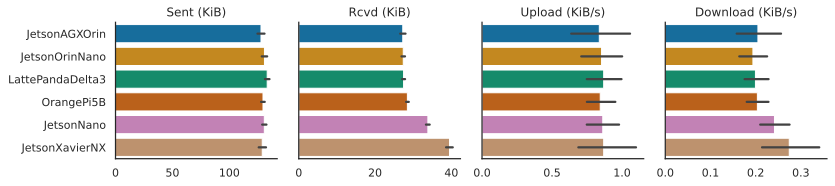

In [56]:
df = job_data["hw_metrics"][["device_type", "CPU Util (%)", "Mem Util (MiB)", "Power (W)"]]
plot_hw_metrics(df, save_name="scrape_hw_1.pdf")

# df = job_data["hw_metrics"][["device_type", "Sent (MiB)", "Rcvd (MiB)", "Upload (MiB/s)", "Download (MiB/s)"]]
df = job_data["hw_metrics"][["device_type", "Sent (KiB)", "Rcvd (KiB)", "Upload (KiB/s)", "Download (KiB/s)"]]
plot_hw_metrics(df, save_name="scrape_hw_2.pdf")


In [3]:
exp_name="test"
job_metric_dir = collect_job_metrics(exp_name)
job_data = read_job_metrics(exp_name, job_metric_dir)